### Importing necessary libraries

In [4]:
import time, os
from datetime import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold,  GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
import imblearn
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import f1_score



# Warning suppression
import warnings
warnings.filterwarnings('ignore')

# 1. Introduction

## 1.1. Data

In [5]:
data = pd.read_csv(r'D:\Data science\Accident-Severity-Prediction-main/Vehicle Collision.csv')
data.head()

,UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,PERSON_ID,PERSON_TYPE,PERSON_INJURY,VEHICLE_ID,PERSON_AGE,EJECTION,...,BODILY_INJURY,POSITION_IN_VEHICLE,SAFETY_EQUIPMENT,PED_LOCATION,PED_ACTION,COMPLAINT,PED_ROLE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2,PERSON_SEX
0,10253606,4230743.0,10/24/2019,19:15,84bcb3a7-d201-4c61-9e30-fe29268c1074,Occupant,Injured,19143343.0,27.0,Not Ejected,...,Back,Driver,Lap Belt & Harness,NaN,NaN,Complaint of Pain or Nausea,Driver,NaN,NaN,M
1,10248708,4229547.0,10/26/2019,1:15,a8904763-2870-42f3-865c-b53d8e5156e2,Pedestrian,Injured,NaN,24.0,NaN,...,Shoulder - Upper Arm,NaN,NaN,Pedestrian/Bicyclist/Other Pedestrian at Inter...,Crossing With Signal,None Visible,Pedestrian,Unspecified,Unspecified,F
2,10254556,4230715.0,10/26/2019,8:50,1a085543-ae9d-4a69-8cd0-fb7b33380a8b,Bicyclist,Injured,19143832.0,42.0,Not Ejected,...,Knee-Lower Leg Foot,Driver,Unknown,NaN,NaN,None Visible,Driver,NaN,NaN,M
3,10250834,4230376.0,10/26/2019,19:40,f58fc41f-497e-4f30-bf49-a9a80adec8b2,Bicyclist,Injured,19141949.0,36.0,Not Ejected,...,Back,Driver,NaN,NaN,NaN,Internal,Driver,NaN,NaN,M
4,10252474,4229773.0,10/26/2019,16:50,4bf13d12-8d7a-4cb0-997f-dd6a8b1adca6,Occupant,Injured,19142773.0,50.0,Not Ejected,...,Head,"Front passenger, if two or more persons, inclu...",Lap Belt & Harness,NaN,NaN,Complaint of Pain or Nausea,Passenger,NaN,NaN,F


## 1.2. Project Objective

The dataset contains extensive information on **12316 accidents**. It has **31 predictor variables** and the **target variable** *Accident_severity* which takes three possible values: **Slight**, **Serious** and **Fatal**. The aim of the project is to build prediction models to classify whether the severity of an accident is slight, serious or fatal, given various relevant information in form of the 31 predictor variables, regarding that particular accident.

## 1.3. Evaluation Metric

**Precision** and **Recall** are universally accepted metrics to capture the performance of a model, when restricted respectively to the **predicted positive class** and the **actual positive class**. Let us denote
- **TP**: Number of true positives
- **TN**: Number of true negatives
- **FP**: Number of false positives
- **FN**: Number of false negatives

In terms of these quantities, **Precision** and **Recall** are defined as

$$\text{Precision} = \frac{TP}{TP + FP},\hspace{0.5cm} \text{Recall} = \frac{TP}{TP + FN}.$$

The **F1-score** provides a balanced measuring stick by considering the *harmonic mean* of the above two matrices.

$$F_1\text{-Score} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}.$$

For its equal emphasis on both *precision* and *recall*, *F1-score* is one of the most suitable metrics for evaluating the models in this project. In the dataset, we have a target variable (*Accident_severity*) that takes three possible values, essentially partitioning the dataset into three target classes. This can be converted to a binary partition by considering one class as the positive class and the rest two combined as the negative class. Now this positive-negative partition can be done from the perspective of each target class, producing three F1-scores. We take the unweighted average (called the **macro F1-score**) as an evaluation metric to assess the models.

# 2. Exploratory Data Analysis

## 2.1. Basic Data Exploration

In [6]:
print("Shape of the data: {}".format(data.shape))

Shape of the data: (230660, 21)


In [7]:
data.columns

Index(['UNIQUE_ID', 'COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME', 'PERSON_ID',
       'PERSON_TYPE', 'PERSON_INJURY', 'VEHICLE_ID', 'PERSON_AGE', 'EJECTION',
       'EMOTIONAL_STATUS', 'BODILY_INJURY', 'POSITION_IN_VEHICLE',
       'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT',
       'PED_ROLE', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2',
       'PERSON_SEX'],
      dtype='object')

In [8]:
print("Total number of columns: {}".format(len(data.columns)))

Total number of columns: 21


In [9]:
print("Number of integer columns: {}".format(data.dtypes.tolist().count(data.dtypes[0])))
print("Number of object columns: {}".format(data.dtypes.tolist().count(data.dtypes[20])))

Number of integer columns: 18
Number of object columns: 18


In [10]:
duplicate = data[data.duplicated() == True]
print("Number of duplicate rows: {}".format(len(duplicate)))

Number of duplicate rows: 0


In [11]:
data.isna().sum()

UNIQUE_ID                     0
COLLISION_ID                  4
CRASH_DATE                    4
CRASH_TIME                    4
PERSON_ID                     7
PERSON_TYPE                   4
PERSON_INJURY                 4
VEHICLE_ID                48723
PERSON_AGE                  997
EJECTION                 127873
EMOTIONAL_STATUS         103742
BODILY_INJURY            103701
POSITION_IN_VEHICLE      127754
SAFETY_EQUIPMENT         140540
PED_LOCATION             204368
PED_ACTION               204430
COMPLAINT                103687
PED_ROLE                 103687
CONTRIBUTING_FACTOR_1    205452
CONTRIBUTING_FACTOR_2    205477
PERSON_SEX               103768
dtype: int64

In [12]:
print("Total number of missing values: {}".format(data.isna().sum().sum()))
print("Number of columns with missing values: {}".format(len(data.isnull().sum().tolist())-data.isnull().sum().tolist().count(0)))
print("Number of columns without missing values: {}".format(data.isnull().sum().tolist().count(0)))

Total number of missing values: 1784226
Number of columns with missing values: 20
Number of columns without missing values: 1


In [13]:
# Summary of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230660 entries, 0 to 230659
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   UNIQUE_ID              230660 non-null  object 
 1   COLLISION_ID           230656 non-null  float64
 2   CRASH_DATE             230656 non-null  object 
 3   CRASH_TIME             230656 non-null  object 
 4   PERSON_ID              230653 non-null  object 
 5   PERSON_TYPE            230656 non-null  object 
 6   PERSON_INJURY          230656 non-null  object 
 7   VEHICLE_ID             181937 non-null  float64
 8   PERSON_AGE             229663 non-null  float64
 9   EJECTION               102787 non-null  object 
 10  EMOTIONAL_STATUS       126918 non-null  object 
 11  BODILY_INJURY          126959 non-null  object 
 12  POSITION_IN_VEHICLE    102906 non-null  object 
 13  SAFETY_EQUIPMENT       90120 non-null   object 
 14  PED_LOCATION           26292 non-nul

In [14]:
print("Number of duplicate observations: {}".format(data.duplicated().sum()))

Number of duplicate observations: 0


In [15]:
data.describe()

,COLLISION_ID,VEHICLE_ID,PERSON_AGE
count,2.306560e+05,1.819370e+05,229663.000000
mean,2.824113e+06,1.567930e+07,36.474029
std,1.497211e+06,3.051295e+06,84.924692
min,3.900000e+01,6.029470e+05,-997.000000
25%,2.812695e+06,1.353522e+07,23.000000
50%,3.474966e+06,1.714574e+07,33.000000
75%,3.873819e+06,1.795996e+07,49.000000
max,4.695378e+06,2.058575e+07,9999.000000


In [16]:
data.describe(include = "all").head(4).T

,count,unique,top,freq
UNIQUE_ID,230660,230660,},1
COLLISION_ID,230656.0,NaN,NaN,NaN
CRASH_DATE,230656,2925,10/31/2019,202
CRASH_TIME,230656,1440,17:00,2847
PERSON_ID,230653,127017,1,75968
PERSON_TYPE,230656,4,Occupant,164237
PERSON_INJURY,230656,2,Injured,229633
VEHICLE_ID,181937.0,NaN,NaN,NaN
PERSON_AGE,229663.0,NaN,NaN,NaN
EJECTION,102787,6,Not Ejected,94848


## 2.2. Data Visualization

In [17]:
data['PERSON_INJURY'].unique()

array(['Injured', 'Killed', nan], dtype=object)

In [18]:
# Value counts of Accident_severity
data['PERSON_INJURY'].value_counts()

PERSON_INJURY
Injured    229633
Killed       1023
Name: count, dtype: int64

In [19]:
# Add annotations
def add_annotations(ax):
    for p in ax.patches:
        frequency = p.get_height()
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(f'{frequency}', (x, y), size = 12, ha = 'center', va = 'bottom')

# Visualization
def count_donut(data, col):
    plt.figure(figsize = (14, 7))

    # Countplot
    ax1 = plt.subplot(1, 2, 1)
    count = sns.countplot(x = data[col])
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    sns.despine(top = True, right = True)
    add_annotations(ax1)

    # Donutplot
    ax2 = plt.subplot(1, 2, 2)
    # Get value counts and corresponding labels, handling potential missing values
    value_counts = data[col].value_counts()
    labels = value_counts.index.tolist()

    plt.pie(value_counts,  # Use value_counts directly
            labels = labels,  # Use labels derived from value_counts
            autopct = '%1.2f%%',
            pctdistance = 0.8,
            shadow = False,
            radius = 1.3,
            textprops = {'fontsize' : 14}
            )
    circle = plt.Circle((0, 0), 0.4, fc = 'white')
    fig = plt.gcf()
    fig.gca().add_artist(circle)
    ax2.set_xlabel('')

    plt.suptitle("Frequency Comparison of {}".format(col), fontsize = 16)
    plt.subplots_adjust(wspace = 0.4)
    plt.show()

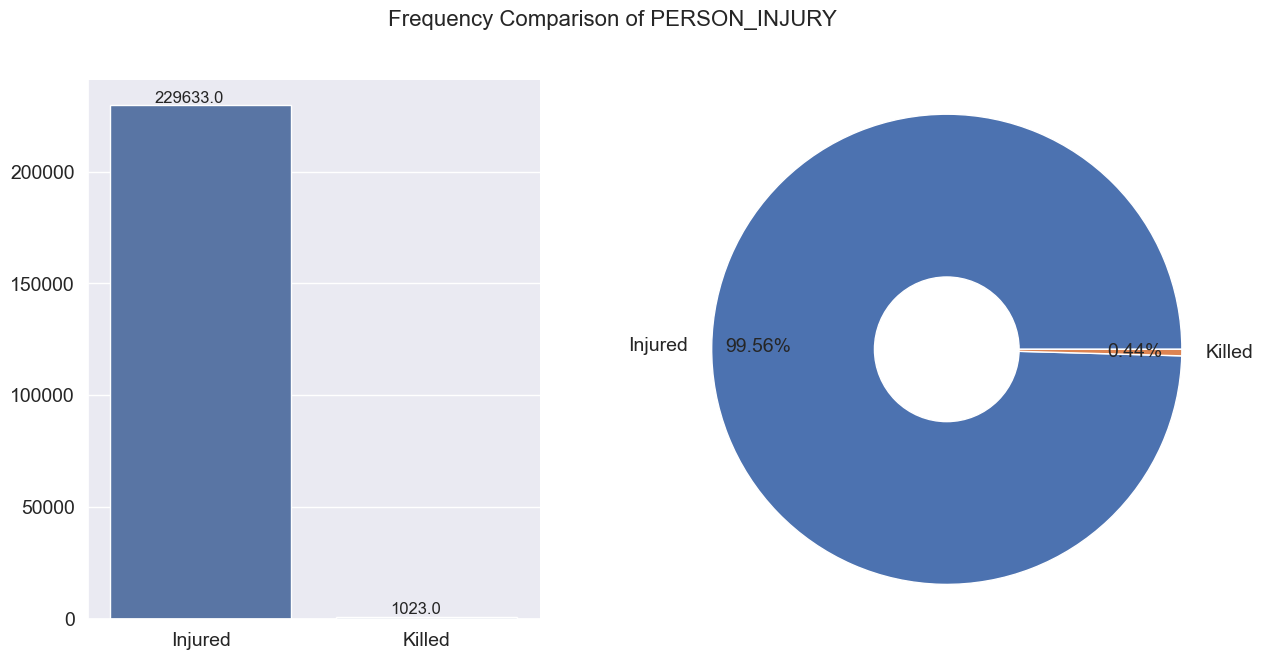

In [20]:
count_donut(data, 'PERSON_INJURY')

Time

In [21]:
def get_hour(CRASH_TIME):
    if isinstance(CRASH_TIME, str):  # Check if CRASH_TIME is already a string
        try:
            value = datetime.strptime(CRASH_TIME, '%H:%M:%S')
        except ValueError:
            value = datetime.strptime(CRASH_TIME, '%H:%M')  # Handle cases without seconds
        return value.hour
    else:
        return None  # Handle non-string values, you might want to log these or handle them differently

data['CRASH_TIME'] = data['CRASH_TIME'].apply(get_hour)

def convert_time(CRASH_TIME):
    if CRASH_TIME >=6 and CRASH_TIME <=18:
        return 'Day'
    else:
        return 'Night'

data['CRASH_TIME'] = data['CRASH_TIME'].apply(convert_time)

In [22]:
data['CRASH_TIME'].value_counts()

CRASH_TIME
Day      151570
Night     79090
Name: count, dtype: int64

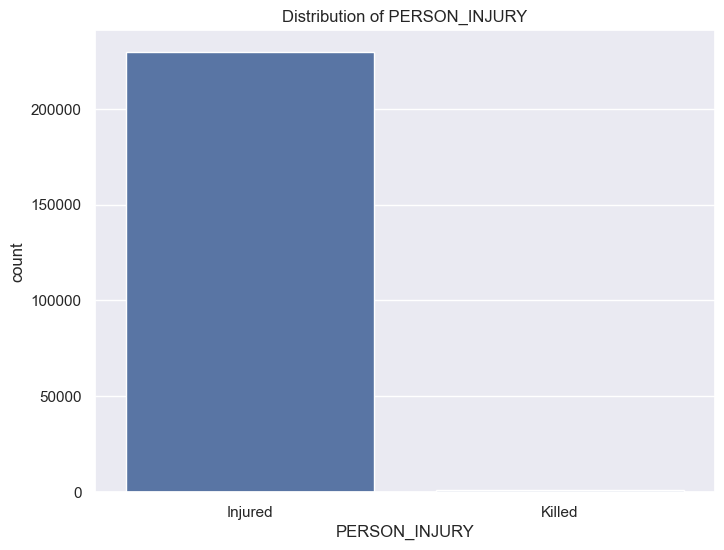

In [23]:
# Distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='PERSON_INJURY', data=data)
plt.title('Distribution of PERSON_INJURY')
plt.show()

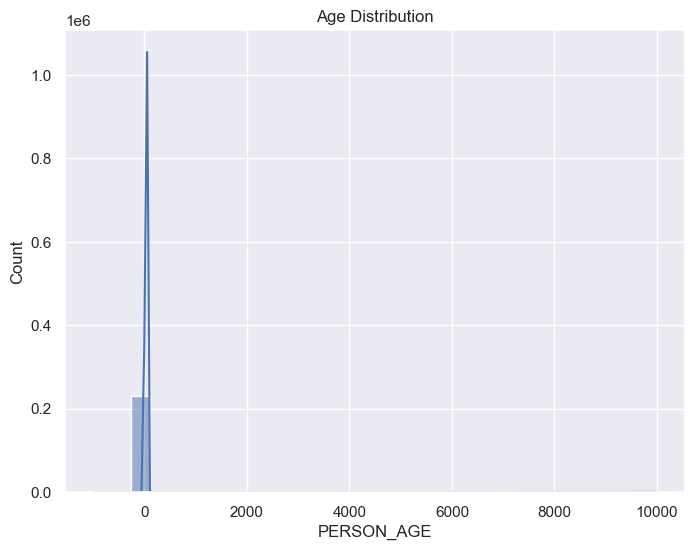

In [24]:
# Age distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['PERSON_AGE'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

Column 'UNIQUE_ID' contains non-numeric values. Unique values:
[10253606 10248708 10254556 ... '  "message" : "Internal error"'
 '  "status" : 500' '}']
Column 'CRASH_DATE' contains non-numeric values. Unique values:
['10/24/2019' '10/26/2019' '06/22/2020' ... '05/10/2020' '06/25/2022' nan]
Column 'CRASH_TIME' contains non-numeric values. Unique values:
['Night' 'Day']
Column 'PERSON_ID' contains non-numeric values. Unique values:
['84bcb3a7-d201-4c61-9e30-fe29268c1074'
 'a8904763-2870-42f3-865c-b53d8e5156e2'
 '1a085543-ae9d-4a69-8cd0-fb7b33380a8b' ...
 'adba8b95-2621-4150-ab30-b5b3970f83b5' '1364374'
 '7a710fd4-d131-4f2f-a7d9-942c34a60fc2']
Column 'PERSON_TYPE' contains non-numeric values. Unique values:
['Occupant' 'Pedestrian' 'Bicyclist' 'Other Motorized' nan]
Column 'PERSON_INJURY' contains non-numeric values. Unique values:
['Injured' 'Killed' nan]
Column 'EJECTION' contains non-numeric values. Unique values:
['Not Ejected' nan 'Ejected' 'Does Not Apply' 'Trapped'
 'Partially Eje

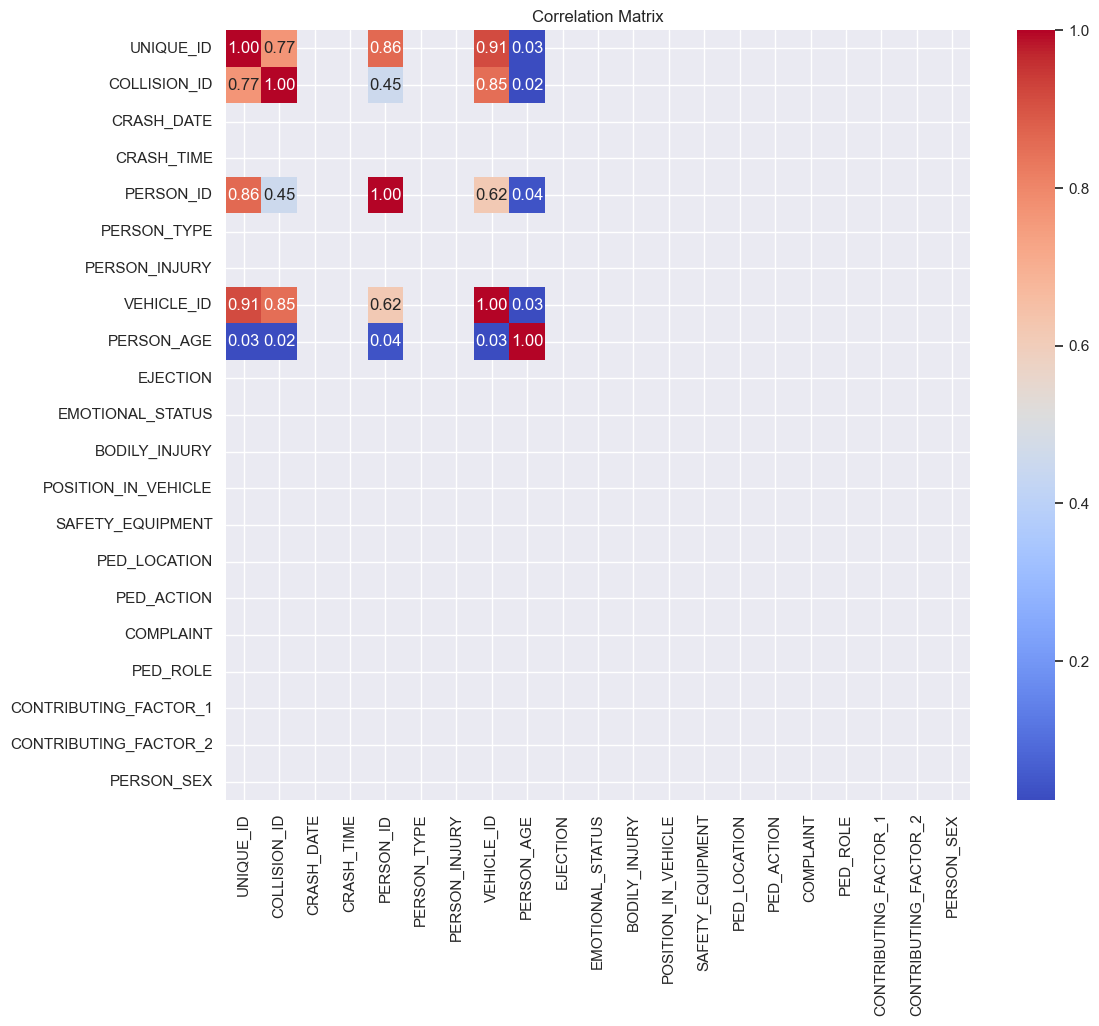

In [25]:
# Attempt to identify non-numeric columns
for col in data.columns:
    if data[col].dtype == object:  # Check if column is of object (string) type
        print(f"Column '{col}' contains non-numeric values. Unique values:")
        print(data[col].unique())  # Print unique values for inspection

# Option 1: Drop non-numeric columns
# If you decide to drop columns with non-numeric data:
data_numeric = data.select_dtypes(include=['number'])  # Select only numeric columns
correlation_matrix = data_numeric.corr()

# Option 2: Handle non-numeric values
# If you want to keep the columns and handle non-numeric values:
# Example: Fill non-numeric values with a placeholder (e.g., NaN)
data_filled = data.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, replace errors with NaN
correlation_matrix = data_filled.corr()

# Continue with your plotting code
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

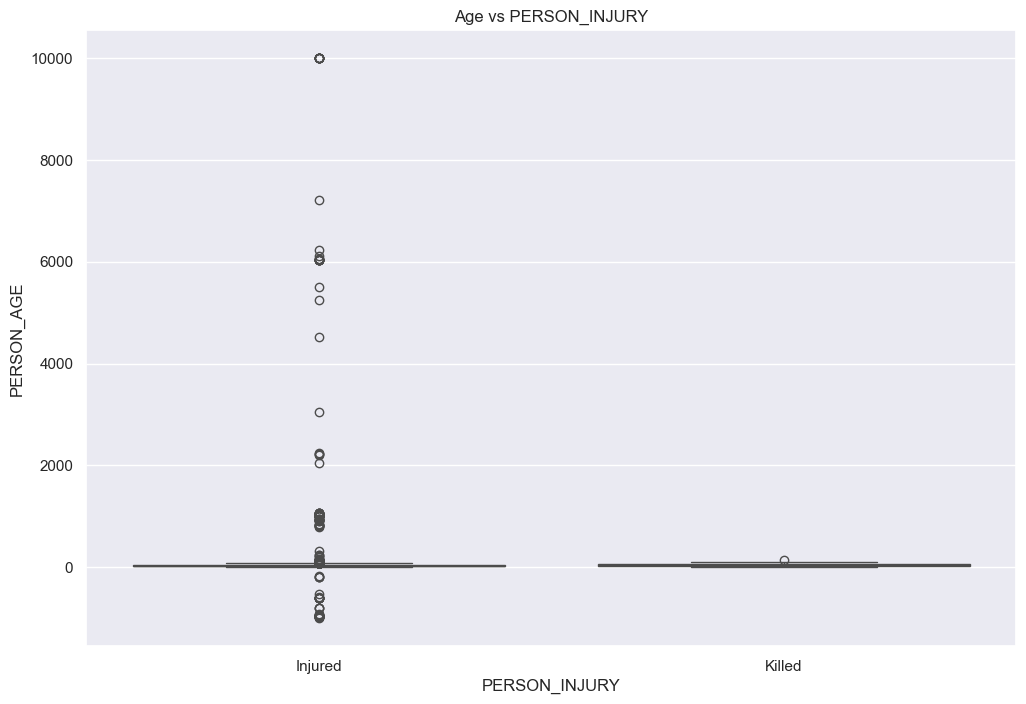

In [26]:
# Boxplot of age by injury type
plt.figure(figsize=(12, 8))
sns.boxplot(x='PERSON_INJURY', y='PERSON_AGE', data=data)
plt.title('Age vs PERSON_INJURY')
plt.show()

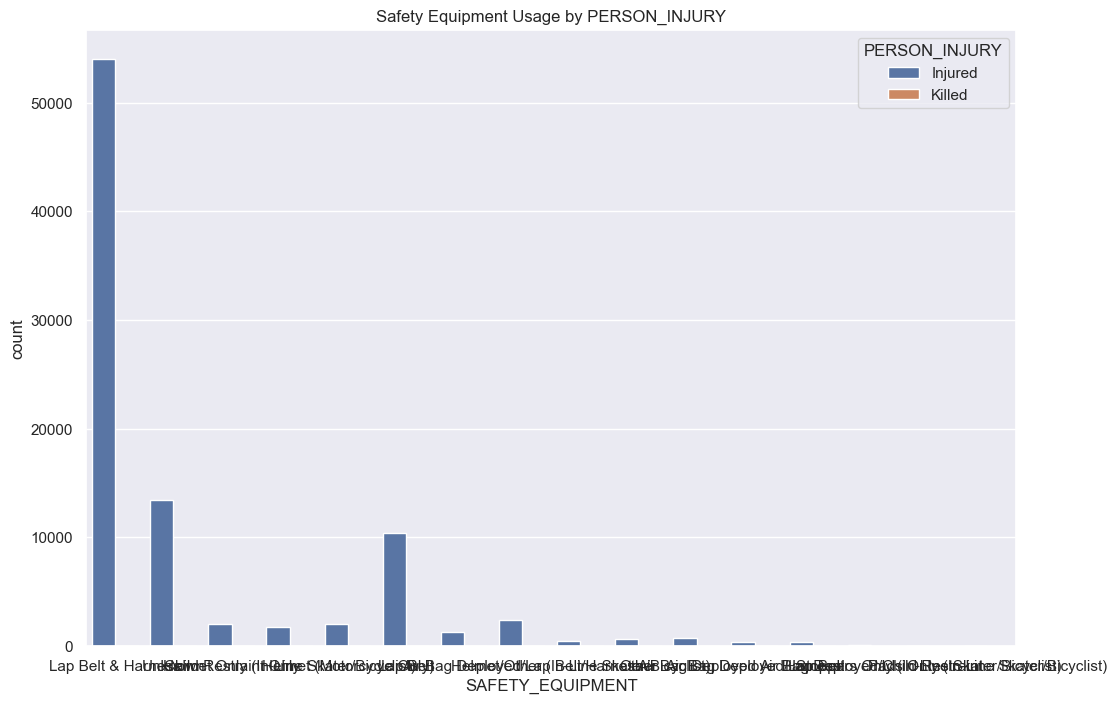

In [27]:
# Countplot of safety equipment usage by injury type
plt.figure(figsize=(12, 8))
sns.countplot(x='SAFETY_EQUIPMENT', hue='PERSON_INJURY', data=data)
plt.title('Safety Equipment Usage by PERSON_INJURY')
plt.show()

### Other features

In [28]:
features_others = [x for x in data.columns.tolist() if x not in ['PERSON_INJURY', 'CRASH_TIME']]

features_horiz = ['PERSON_SEX', 'POSITION_IN_VEHICLE', 'SAFETY_EQUIPMENT',
                   'PERSON_TYPE', 'PERSON_AGE', 'PED_ROLE', 'CONTRIBUTING_FACTOR_1']



In [29]:
# for feature in features_others:
#     plt.figure(figsize = (10, 5))
#     catplot = sns.catplot(data = data, x = feature, col = 'PERSON_INJURY', kind = 'count', sharey = False)
#     if feature not in features_horiz:
#         catplot.set_xticklabels(rotation = 90)
#     plt.suptitle("Frequency distribution of {} by target class".format(feature), y = 1.1, fontsize = 15)
#     plt.show()

# 3. Data Preprocessing

## 3.1. Outlier Detection

In [30]:
# # Boxplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))
# sns.boxplot(data = data, x = 'Number_of_vehicles_involved', y = 'PERSON_INJURY', ax = ax1)
# sns.boxplot(data = data, x = 'Number_of_casualties', y = 'PERSON_INJURY', ax = ax2).set(yticklabels = [])
# ax2.set_ylabel('')
# plt.show()

## 3.2. Missing Data Imputation

In [31]:
# Combining similar values
def combine_similar(data):
  data = data.replace('Unknown', 'unknown')
  data = data.replace('Other', 'other')
  data = data.replace('Unknown or other', 'other')
  data = data.replace('Darkness - lights unlit', 'Darkness - no lighting')
  data['PERSON_TYPE'] = data['PERSON_TYPE'].replace('5', 'Under 18')
  return data

In [32]:
data = combine_similar(data)

In [33]:
# Columns with missing values (sorted by count)
data.isna().sum()[data.isna().sum() != 0].sort_values(ascending = False)

CONTRIBUTING_FACTOR_2    205477
CONTRIBUTING_FACTOR_1    205452
PED_ACTION               204430
PED_LOCATION             204368
SAFETY_EQUIPMENT         140540
EJECTION                 127873
POSITION_IN_VEHICLE      127754
PERSON_SEX               103768
EMOTIONAL_STATUS         103742
BODILY_INJURY            103701
COMPLAINT                103687
PED_ROLE                 103687
VEHICLE_ID                48723
PERSON_AGE                  997
PERSON_ID                     7
CRASH_DATE                    4
COLLISION_ID                  4
PERSON_INJURY                 4
PERSON_TYPE                   4
dtype: int64

In [34]:
# Rows with missing values (sorted by count)
data.T.isna().sum()[data.T.isna().sum() != 0].sort_values(ascending = False)

230659    19
230658    19
230656    19
230657    19
6037      14
          ..
109928     1
109271     1
108637     1
107482     1
5084       1
Length: 230659, dtype: int64

In [35]:
# Converting unknown/other/na to nan
def more_missing(data):

    data = data.replace('unknown', np.nan)
    data = data.replace('other', np.nan)
    data = data.replace('na', np.nan)
    return data

In [36]:
data = more_missing(data)


### Mode imputation

In [37]:
def mode_imputer(data):
    data_imputed = data.copy(deep = True)
    imputer = SimpleImputer(strategy = 'most_frequent')
    data_imputed.iloc[:,:] = imputer.fit_transform(data_imputed)
    return data_imputed

### Assigning to 'unknown' category

In [38]:
# Function to assign the missing values to the 'unknown' category
def unknown_imputer(data):
    data_unknown = data.copy(deep = True)
    data_unknown = data_unknown.replace(np.nan, 'Unknown')
    return data_unknown

### Proportion-based imputation

With the goal of keeping the feature distributions same before and after imputation, we impute the missing values in a column in such a way so that the proportions of the existing unique values in the column remain roughly same as those were prior to the imputation.

In [39]:
def prop_imputer(data):
    data_prop = data.copy(deep = True)
    missing_cols = data_prop.isna().sum()[data_prop.isna().sum() != 0].index.tolist()
    for col in missing_cols:
        values_col = data_prop[col].value_counts(normalize = True).index.tolist()
        probabilities_col = data_prop[col].value_counts(normalize = True).values.tolist()
        data_prop[col] = data_prop[col].fillna(pd.Series(np.random.choice(values_col, p = probabilities_col, size = len(data))))
    return data_prop

### Frequency distribution before and after imputation

In [40]:
data_imp = prop_imputer(data)


In [41]:
# for feature in features_others:
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
#     ax1 = sns.countplot(data[feature], ax = ax1)
#     ax2 = sns.countplot(data_imp[feature], ax = ax2)
# ax2.set_ylabel('') if feature not in features_horiz:
# ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)
# ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90)
# plt.suptitle("Frequency distribution of {} before and after
# imputation".format(feature), y = 1.1, fontsize = 15) plt.show() %%

In [42]:
data = data_imp
data.head()

,UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,PERSON_ID,PERSON_TYPE,PERSON_INJURY,VEHICLE_ID,PERSON_AGE,EJECTION,...,BODILY_INJURY,POSITION_IN_VEHICLE,SAFETY_EQUIPMENT,PED_LOCATION,PED_ACTION,COMPLAINT,PED_ROLE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2,PERSON_SEX
0,10253606,4230743.0,10/24/2019,Night,84bcb3a7-d201-4c61-9e30-fe29268c1074,Occupant,Injured,19143343.0,27.0,Not Ejected,...,Back,Driver,Lap Belt & Harness,Pedestrian/Bicyclist/Other Pedestrian at Inter...,Does Not Apply,Complaint of Pain or Nausea,Driver,Unspecified,Unspecified,M
1,10248708,4229547.0,10/26/2019,Night,a8904763-2870-42f3-865c-b53d8e5156e2,Pedestrian,Injured,17942155.0,24.0,Not Ejected,...,Shoulder - Upper Arm,Driver,Lap Belt & Harness,Pedestrian/Bicyclist/Other Pedestrian at Inter...,Crossing With Signal,None Visible,Pedestrian,Unspecified,Unspecified,F
2,10254556,4230715.0,10/26/2019,Day,1a085543-ae9d-4a69-8cd0-fb7b33380a8b,Bicyclist,Injured,19143832.0,42.0,Not Ejected,...,Knee-Lower Leg Foot,Driver,Lap Belt & Harness,Pedestrian/Bicyclist/Other Pedestrian at Inter...,"Crossing, No Signal, or Crosswalk",None Visible,Driver,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,Unspecified,M
3,10250834,4230376.0,10/26/2019,Night,f58fc41f-497e-4f30-bf49-a9a80adec8b2,Bicyclist,Injured,19141949.0,36.0,Not Ejected,...,Back,Driver,Helmet (Motorcycle Only),Pedestrian/Bicyclist/Other Pedestrian Not at I...,Other Actions in Roadway,Internal,Driver,Unspecified,Unspecified,M
4,10252474,4229773.0,10/26/2019,Day,4bf13d12-8d7a-4cb0-997f-dd6a8b1adca6,Occupant,Injured,19142773.0,50.0,Not Ejected,...,Head,"Front passenger, if two or more persons, inclu...",Lap Belt & Harness,Pedestrian/Bicyclist/Other Pedestrian Not at I...,Not in Roadway,Complaint of Pain or Nausea,Passenger,Unspecified,Unspecified,F


In [43]:
data.isna().sum()

UNIQUE_ID                0
COLLISION_ID             0
CRASH_DATE               0
CRASH_TIME               0
PERSON_ID                0
PERSON_TYPE              0
PERSON_INJURY            0
VEHICLE_ID               0
PERSON_AGE               0
EJECTION                 0
EMOTIONAL_STATUS         0
BODILY_INJURY            0
POSITION_IN_VEHICLE      0
SAFETY_EQUIPMENT         0
PED_LOCATION             0
PED_ACTION               0
COMPLAINT                0
PED_ROLE                 0
CONTRIBUTING_FACTOR_1    0
CONTRIBUTING_FACTOR_2    0
PERSON_SEX               0
dtype: int64

## 3.3. Categorical Data Encoding

In [44]:
numerical_cols = ['UNIQUE_ID', 'COLLISION_ID', 'PERSON_ID', 'VEHICLE_ID', 'PERSON_AGE']
ordinal_cols = ['PERSON_INJURY']
nominal_cols = [x for x in data.columns if x not in numerical_cols + ordinal_cols]

### Label encoding

In [45]:
# Dict for saving model and encoder
saved_dict = {}

def label_encoder(data, cols):
    data_le = data.copy(deep = True)
    for col in cols:
        print(f'Encoding {col}')
        le = LabelEncoder()
        data_le[col] = le.fit_transform(data_le[col])
        saved_dict[f'le_{col}'] = le
    return data_le

### Manual encoding of ordinal variables

In [46]:
Age_band_of_driver_dict = {'Under 18': 1,'18-30': 2,'31-50': 3,'Over 51': 4,'unknown': 10}
Position_in_vehicle_dict = {'Driver': 1,'Front Passenger': 2,'Rear Passenger': 3,'Other': 4,'Unknown': 10}
Safety_equipment_dict = {'None': 0,'Seat Belt': 1,'Child Restraint': 2,'Helmet': 3,'Other': 4,'Unknown': 10}
Ped_location_dict = {'Crosswalk': 1,'Not in Crosswalk': 2,'Sidewalk': 3,'Other': 4,'Unknown': 10}
Ped_action_dict = {'Crossing with Signal': 1,'Crossing against Signal': 2,'Standing': 3,'Walking': 4,'Running': 5,'Other': 6,'Unknown': 10}
Complaint_dict = {'No Complaint': 0,'Minor': 1,'Moderate': 2,'Severe': 3,'Fatal': 4,'Unknown': 10}
Ped_role_dict = {'Pedestrian': 1,'Bicyclist': 2,'Other': 3,'Unknown': 10}
Contributing_factor_dict = {'Driver Inattention': 1,'Failure to Yield Right-of-Way': 2,'Following Too Closely': 3,'Backing Unsafely': 4,'Driver Inexperience': 5,'Alcohol Involvement': 6,'Other': 7,'Unknown': 10}
Person_type_dict = {'Driver': 1,'Passenger': 2,'Pedestrian': 3,'Bicyclist': 4,'Other': 5,'Unknown': 10}
Person_injury_dict = {'Fatal': 1,'Serious': 2,'Minor': 3,'None': 4,'Unknown': 10}
Bodily_injury_dict = {'None': 0,'Minor': 1,'Moderate': 2,'Severe': 3,'Fatal': 4,'Unknown': 10}
Ejection_dict = {'None': 0,'Partial': 1,'Complete': 2,'Unknown': 10}
Person_sex_dict = {'Male': 1,'Female': 2,'Unknown': 10}

In [47]:
manual_encoder_dict = {
    "PERSON_AGE": Age_band_of_driver_dict,
    "POSITION_IN_VEHICLE": Position_in_vehicle_dict,
    "SAFETY_EQUIPMENT": Safety_equipment_dict,
    "PED_LOCATION": Ped_location_dict,
    "PED_ACTION": Ped_action_dict,
    "COMPLAINT": Complaint_dict,
    "PED_ROLE": Ped_role_dict,
    "CONTRIBUTING_FACTOR_1": Contributing_factor_dict,
    "CONTRIBUTING_FACTOR_2": Contributing_factor_dict,
    "PERSON_TYPE": Person_type_dict,
    "PERSON_INJURY": Person_injury_dict,
    "BODILY_INJURY": Bodily_injury_dict,
    "EJECTION": Ejection_dict,
    "PERSON_SEX": Person_sex_dict
}

In [48]:
def manual_encoder(data, ordinal_cols, manual_encoder_dict):
    data_me = data.copy(deep = True)
    for feature in data.columns:
        if feature in ordinal_cols:
            if feature != 'PERSON_INJURY':
                data_me[feature] = data_me[feature].map(manual_encoder_dict[feature])
    return data_me

In [49]:
data = manual_encoder(data, ordinal_cols, manual_encoder_dict)
data = label_encoder(data, nominal_cols)
data.head()

Encoding CRASH_DATE
Encoding CRASH_TIME
Encoding PERSON_TYPE
Encoding EJECTION
Encoding EMOTIONAL_STATUS
Encoding BODILY_INJURY
Encoding POSITION_IN_VEHICLE
Encoding SAFETY_EQUIPMENT
Encoding PED_LOCATION
Encoding PED_ACTION
Encoding COMPLAINT
Encoding PED_ROLE
Encoding CONTRIBUTING_FACTOR_1
Encoding CONTRIBUTING_FACTOR_2
Encoding PERSON_SEX


,UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,PERSON_ID,PERSON_TYPE,PERSON_INJURY,VEHICLE_ID,PERSON_AGE,EJECTION,...,BODILY_INJURY,POSITION_IN_VEHICLE,SAFETY_EQUIPMENT,PED_LOCATION,PED_ACTION,COMPLAINT,PED_ROLE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2,PERSON_SEX
0,10253606,4230743.0,2421,1,84bcb3a7-d201-4c61-9e30-fe29268c1074,1,Injured,19143343.0,27.0,2,...,1,2,11,2,4,3,0,47,42,1
1,10248708,4229547.0,2438,1,a8904763-2870-42f3-865c-b53d8e5156e2,3,Injured,17942155.0,24.0,2,...,12,2,11,2,1,14,3,47,42,0
2,10254556,4230715.0,2438,0,1a085543-ae9d-4a69-8cd0-fb7b33380a8b,0,Injured,19143832.0,42.0,2,...,10,2,11,2,3,14,0,34,42,1
3,10250834,4230376.0,2438,1,f58fc41f-497e-4f30-bf49-a9a80adec8b2,0,Injured,19141949.0,36.0,2,...,1,2,7,1,9,10,0,47,42,1
4,10252474,4229773.0,2438,0,4bf13d12-8d7a-4cb0-997f-dd6a8b1adca6,1,Injured,19142773.0,50.0,2,...,8,3,11,1,8,3,2,47,42,0


<Figure size 1000x500 with 0 Axes>

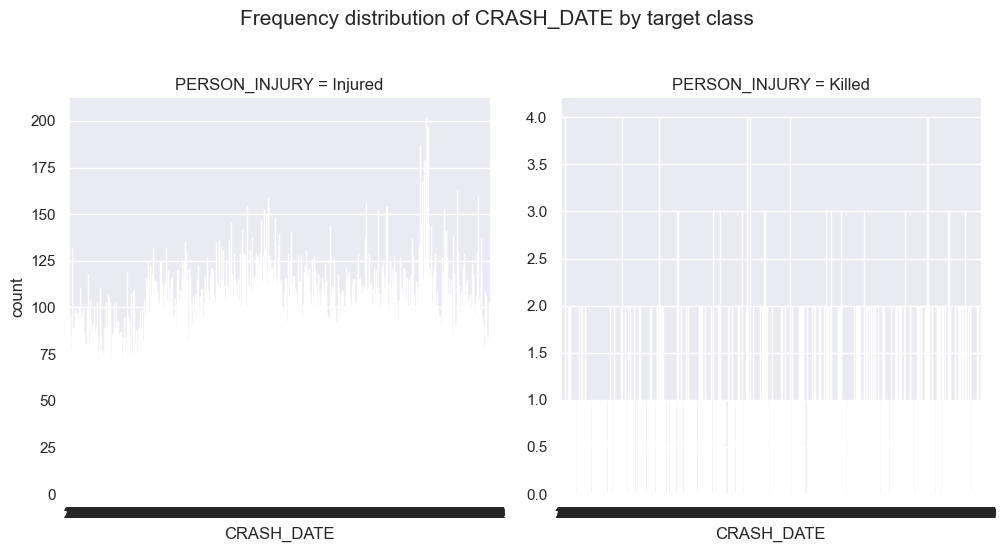

<Figure size 1000x500 with 0 Axes>

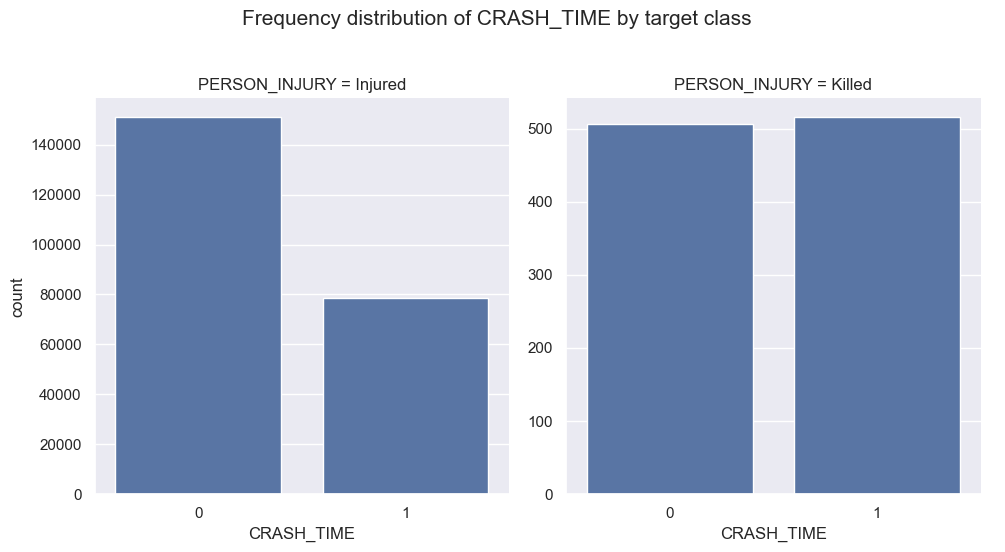

<Figure size 1000x500 with 0 Axes>

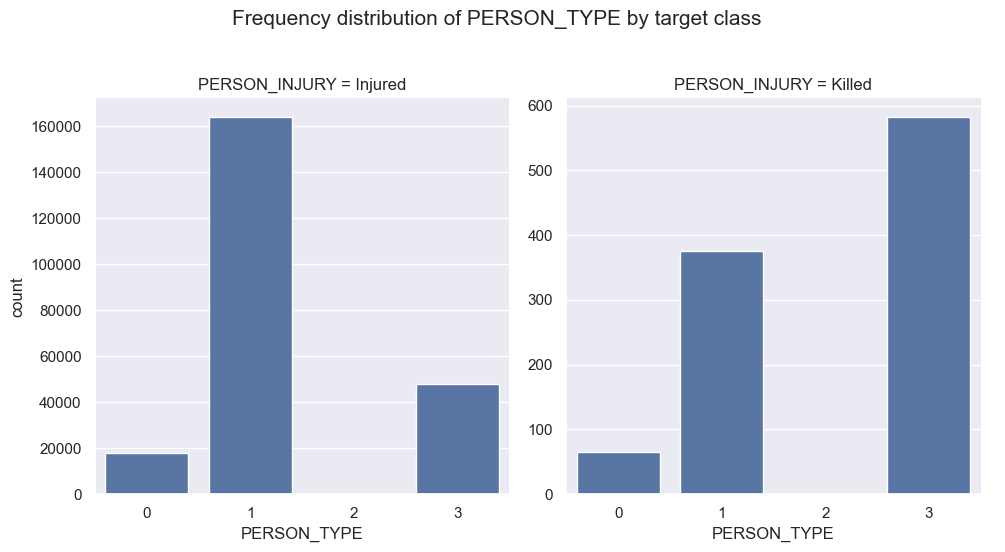

<Figure size 1000x500 with 0 Axes>

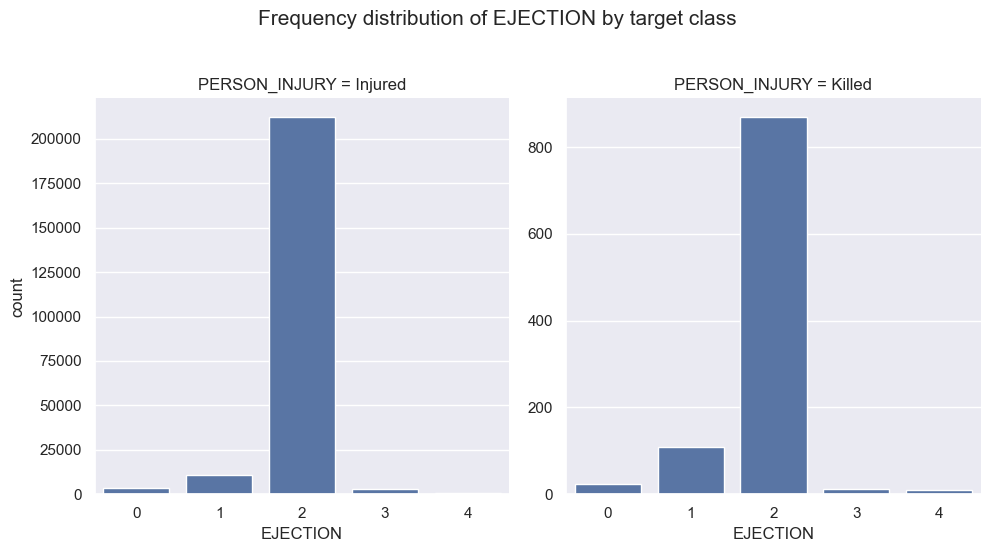

<Figure size 1000x500 with 0 Axes>

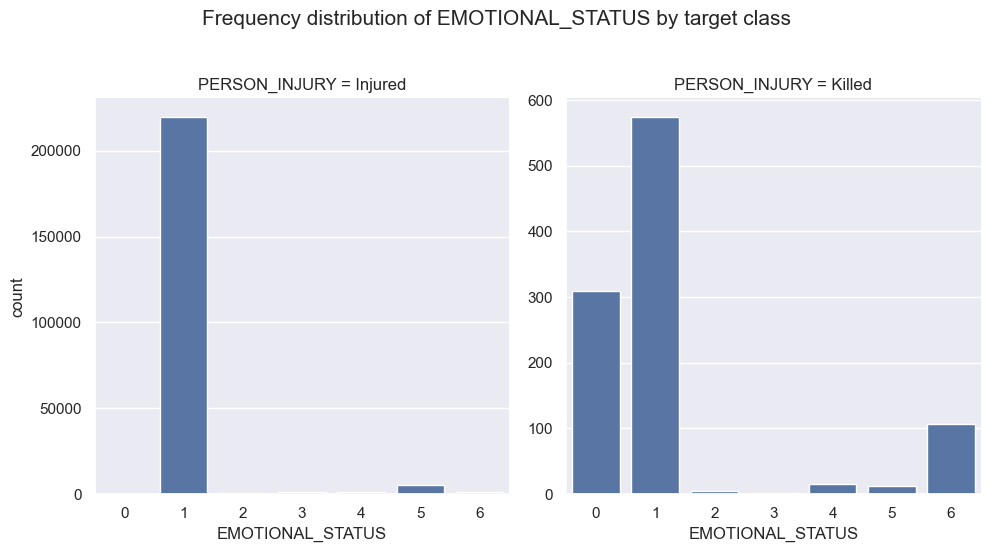

<Figure size 1000x500 with 0 Axes>

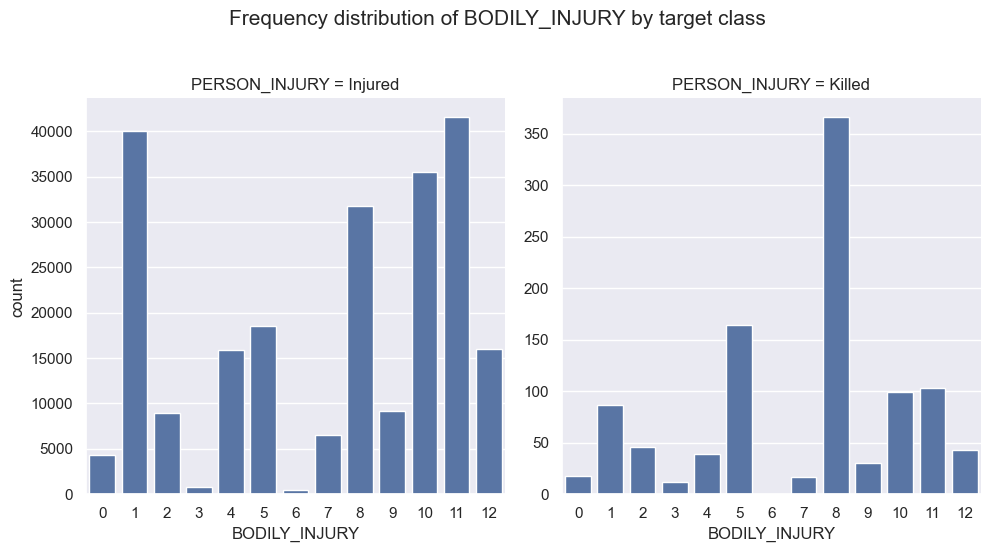

<Figure size 1000x500 with 0 Axes>

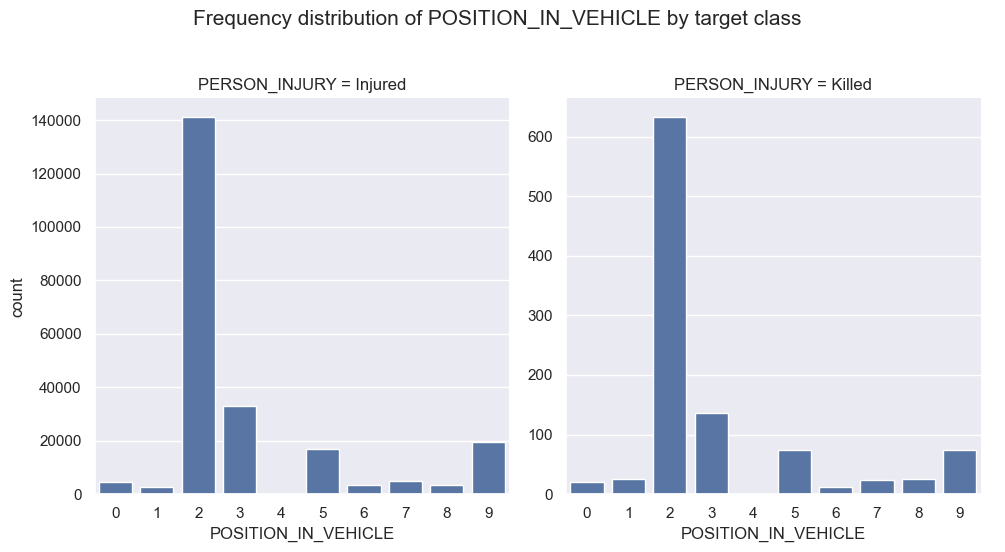

<Figure size 1000x500 with 0 Axes>

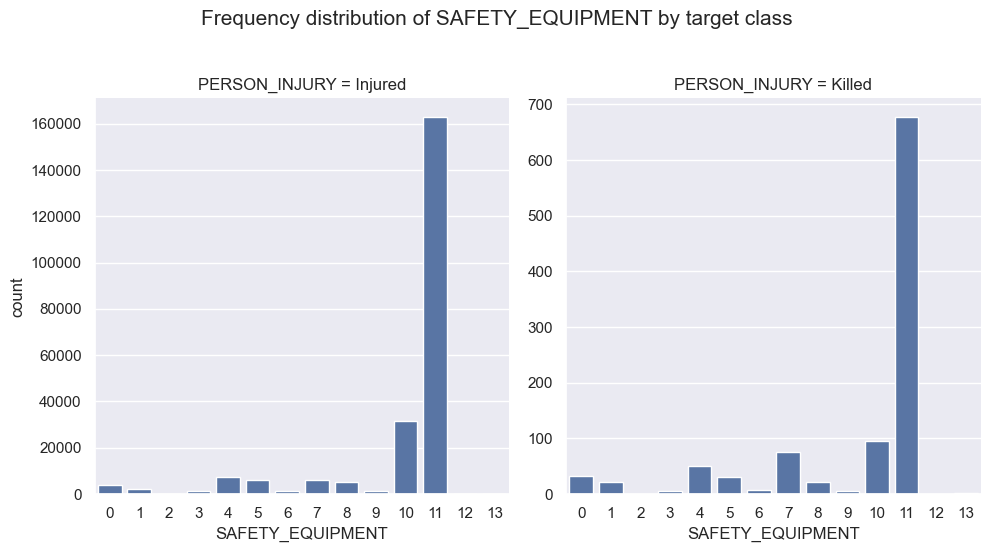

<Figure size 1000x500 with 0 Axes>

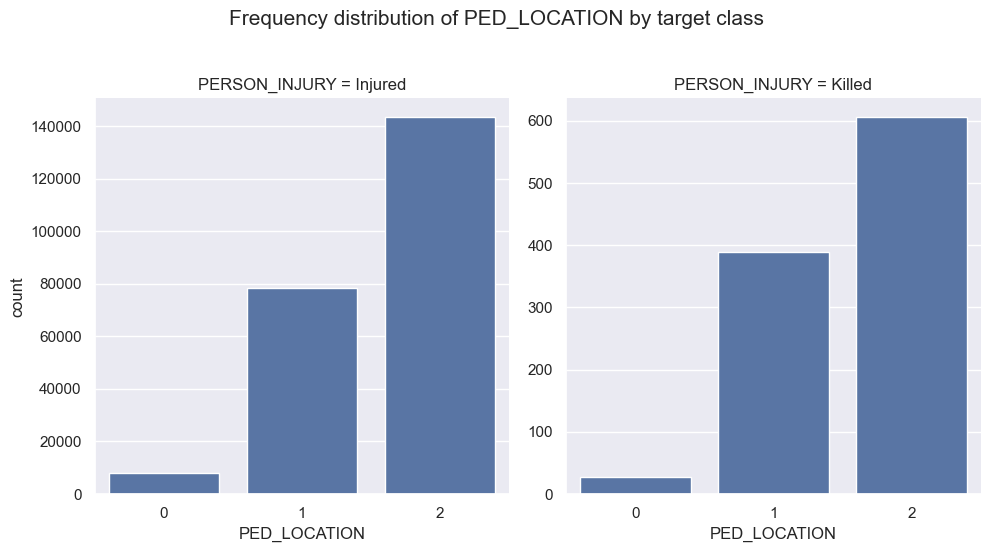

<Figure size 1000x500 with 0 Axes>

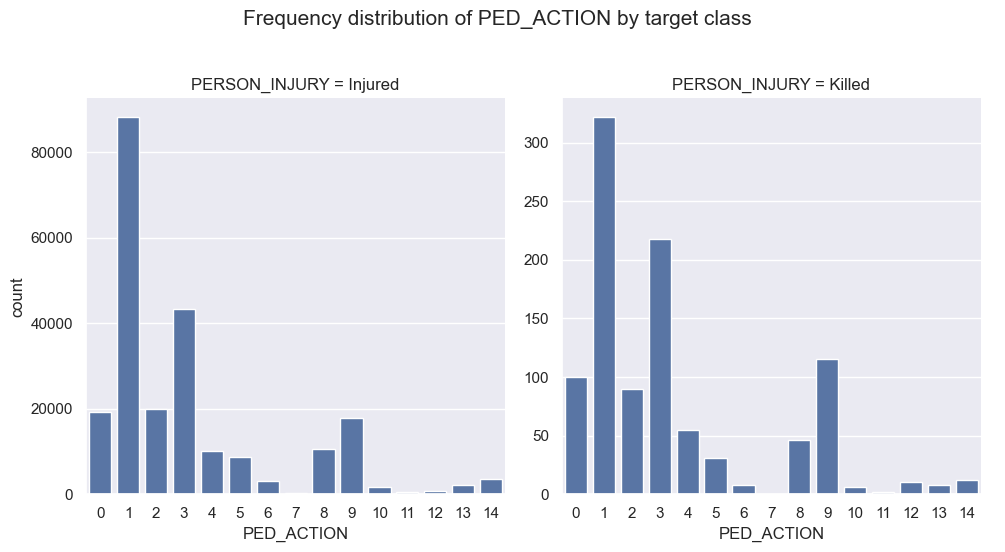

<Figure size 1000x500 with 0 Axes>

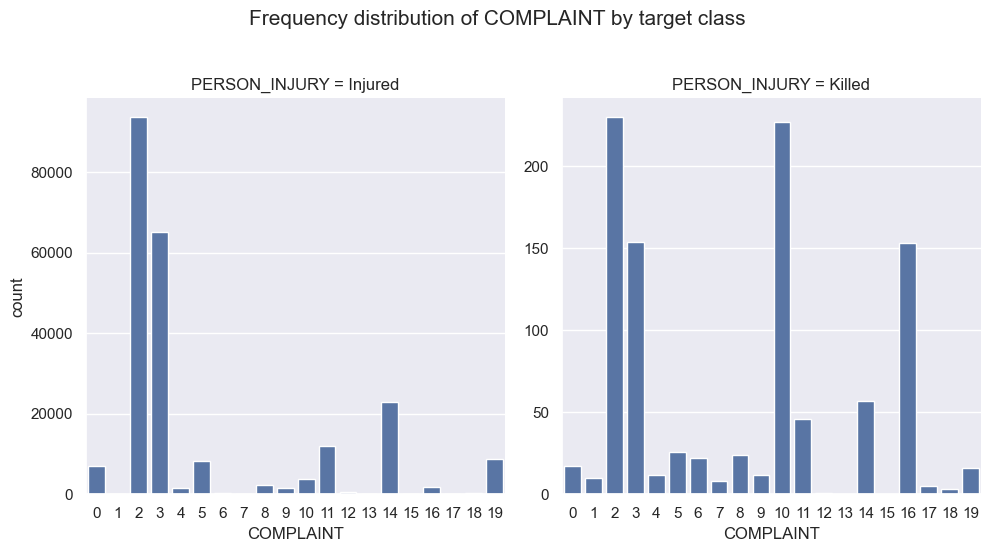

<Figure size 1000x500 with 0 Axes>

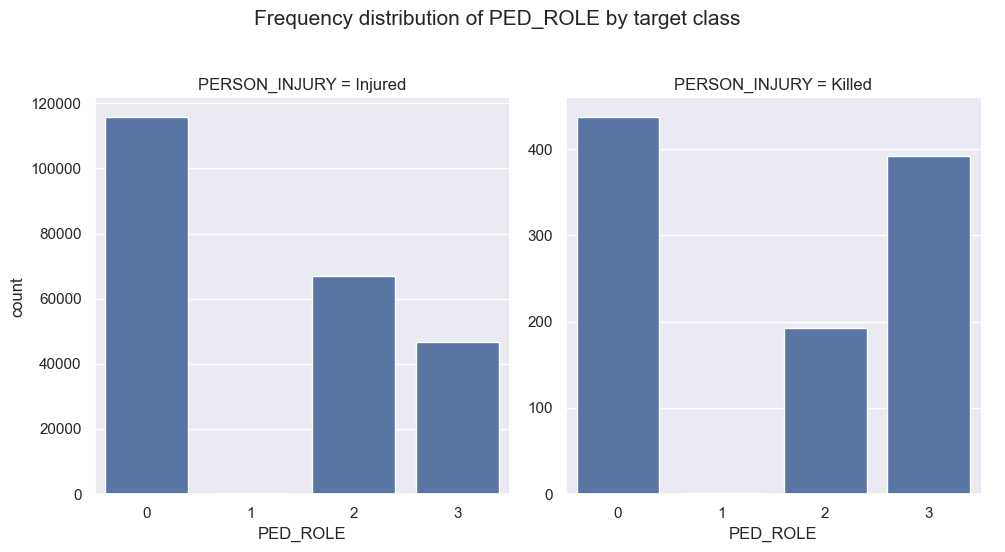

<Figure size 1000x500 with 0 Axes>

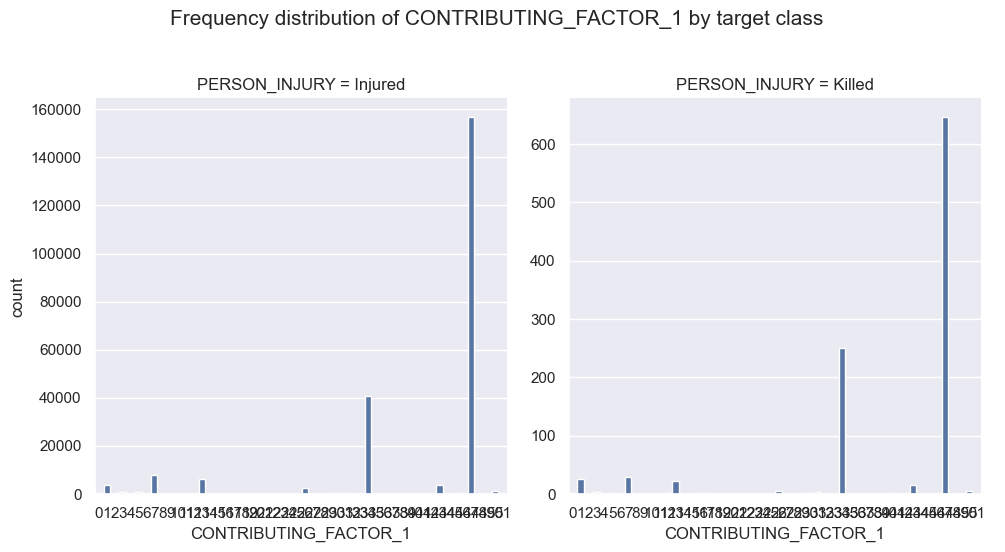

<Figure size 1000x500 with 0 Axes>

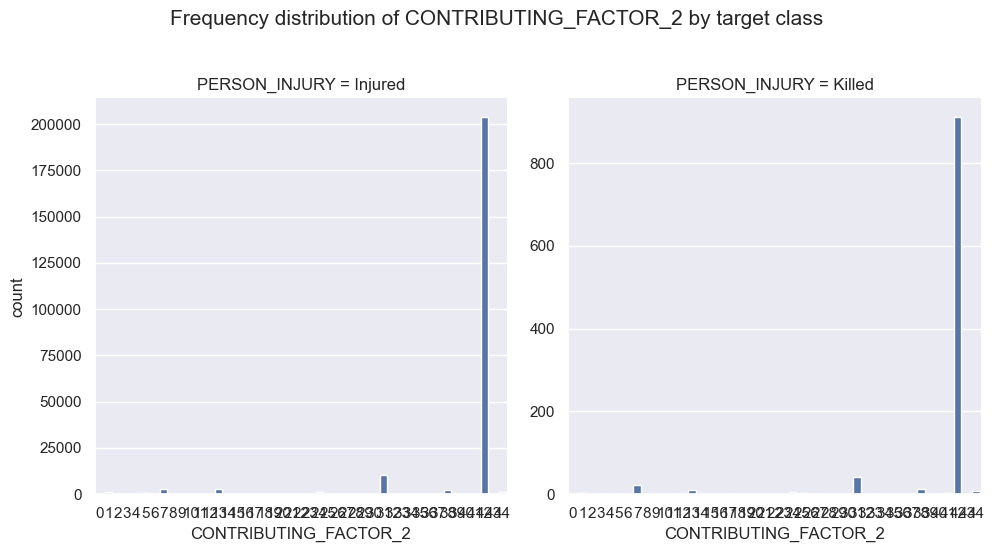

<Figure size 1000x500 with 0 Axes>

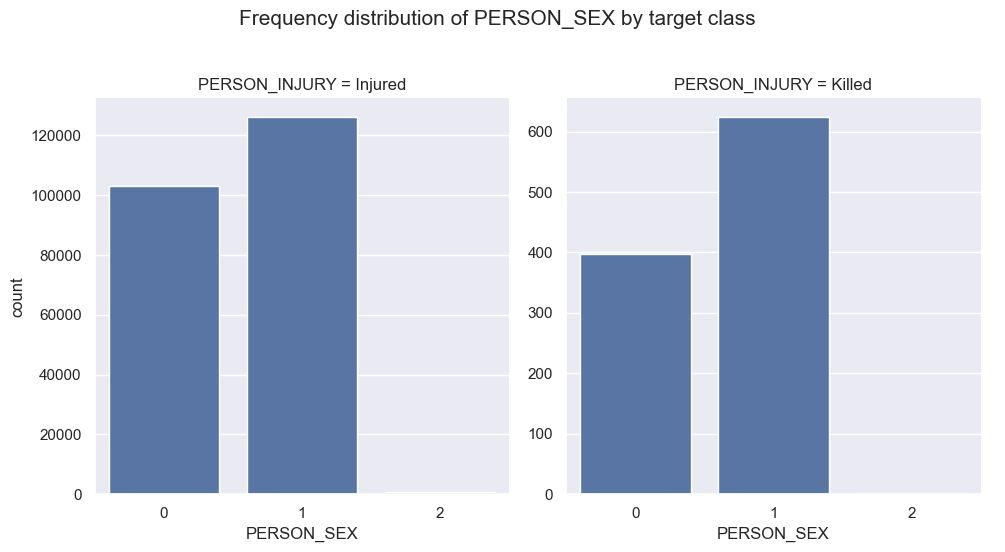

<Figure size 640x480 with 0 Axes>

In [50]:
# Catplot to compare frequency distributions of categorical features across target classes
for feature in ordinal_cols + nominal_cols:
    if feature != 'PERSON_INJURY':
        plt.figure(figsize = (10, 5))
        catplot = sns.catplot(data = data, x = feature, col = 'PERSON_INJURY', kind = 'count', sharey = False)
        plt.suptitle("Frequency distribution of {} by target class".format(feature), y = 1.1, fontsize = 15)
        plt.show()
plt.tight_layout()

In [51]:
def heatmap(data):
    # Convert all columns to numeric, replacing non-convertible values with NaN
    data_numeric = data.apply(pd.to_numeric, errors='coerce')

    # Drop columns with all NaN values, as they cannot be used for correlation calculation
    data_numeric = data_numeric.dropna(axis=1, how='all')

    plt.figure(figsize = (36, 27))
    sns.heatmap(data_numeric.corr(), annot = True, cmap = plt.cm.CMRmap_r)

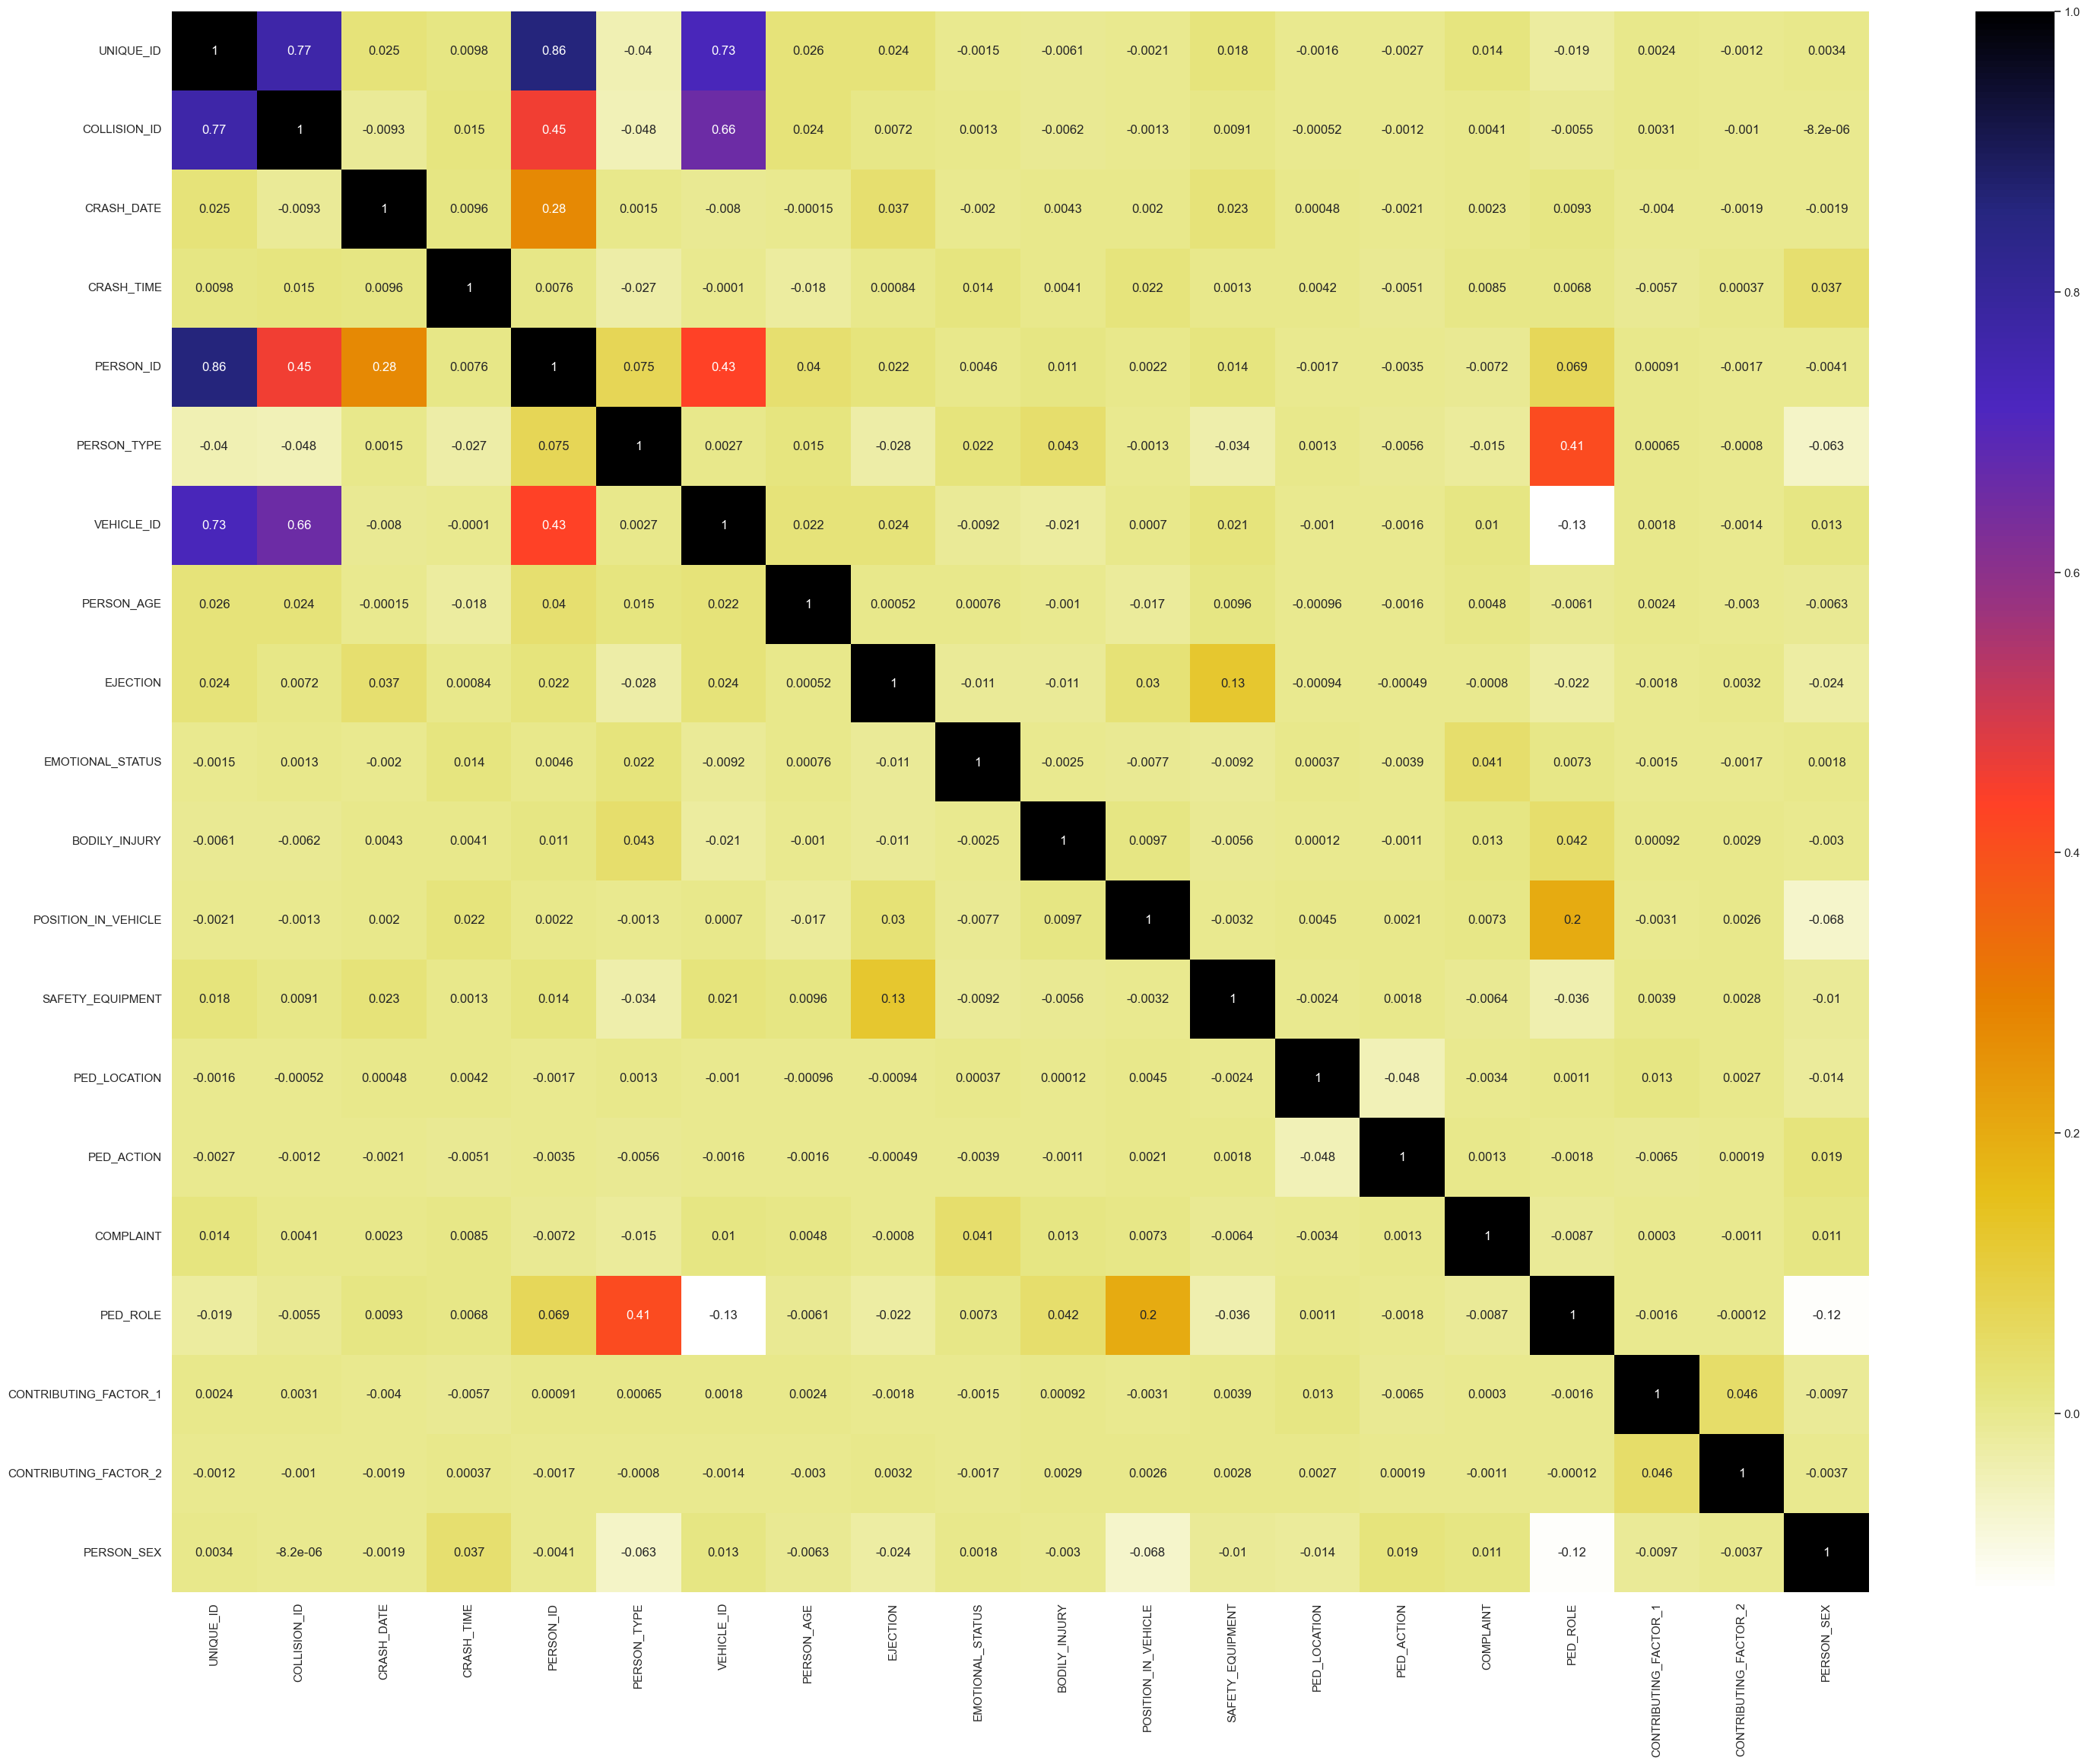

In [52]:
data_heat = data.drop('PERSON_INJURY', axis = 1)
heatmap(data_heat)

In [53]:
# Drop columns
columns_to_drop = ['EJECTION', 'BODILY_INJURY', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT', 'PED_ROLE']
df_dropped = data.drop(columns=columns_to_drop)

## 3.4. Predictor-Target Split


In [54]:
def predictor_target_split(data, target):
    y = data[target]
    X = data.drop(target, axis = 1)
    return X, y

In [55]:
X, y = predictor_target_split(data, 'PERSON_INJURY')

## 3.5. Train-Test Split


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

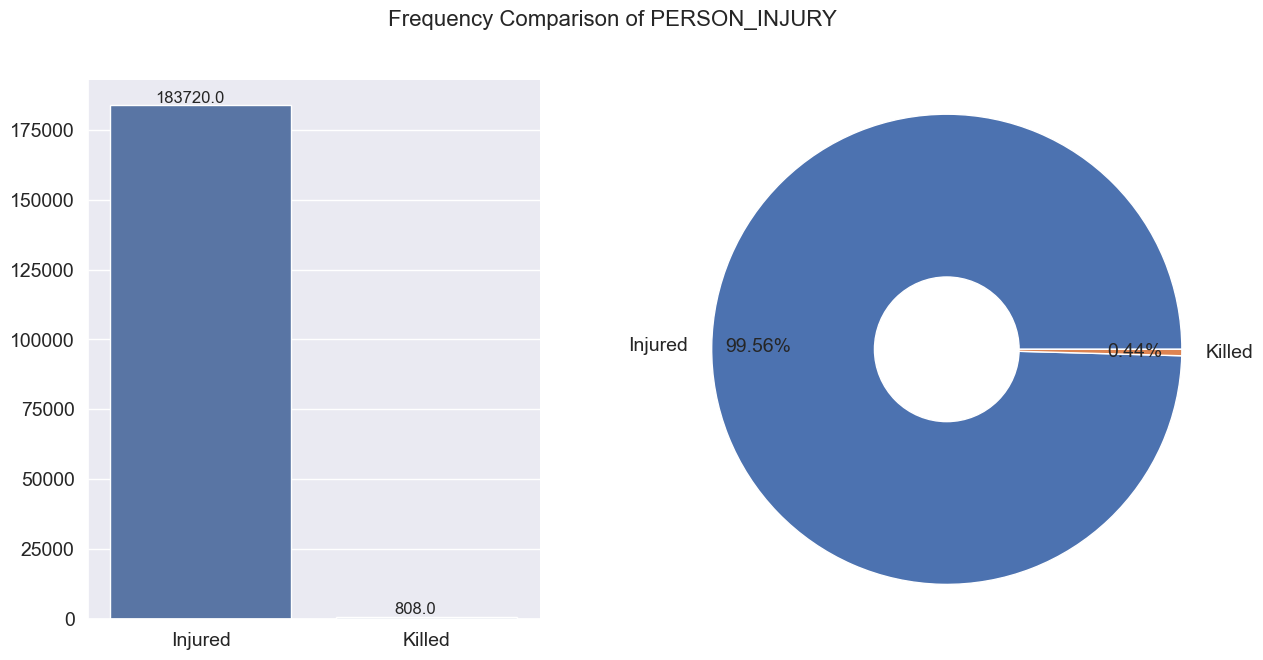

In [57]:
y_train_df = pd.DataFrame(y_train)
count_donut(y_train_df, 'PERSON_INJURY')

## 3.6. Sampling

In [58]:
def rus(X_train, y_train):
  rusil = RandomUnderSampler(random_state = 42, replacement = True)
  X_train_rusil, y_train_rusil = rusil.fit_resample(X_train, y_train)
  return X_train_rusil, y_train_rusil

In [59]:
def ros(X_train, y_train):
  rosil = RandomOverSampler(random_state = 42)
  X_train_rosil, y_train_rosil = rosil.fit_resample(X_train, y_train)
  return X_train_rosil, y_train_rosil

In [60]:
def smote(X_train, y_train):
  smote = SMOTE(random_state = 42, n_jobs = -1)
  X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
  return X_train_smote, y_train_smote

In [61]:
def nm(X_train, y_train):
  nm = NearMiss()
  X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)
  return X_train_nm, y_train_nm

In [62]:
def resampler(X_train, y_train, method = smote, countplot = True):
    if method not in [rus, ros, smote, nm]:
      print("Method invalid")
    else:
      X_train_new, y_train_new = method(X_train, y_train)
    if countplot == True:
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
      ax1 = sns.countplot(y_train, ax = ax1)
      ax2 = sns.countplot(y_train_new, ax = ax2)
      ax2.set_ylabel('')
      plt.suptitle("Frequency distribution of target variable in the training set before and after resampling", y = 1.1, fontsize = 15)
      plt.subplots_adjust(wspace = 0.4)
      plt.show()
    return X_train_new, y_train_new


In [63]:
# X_train, y_train = resampler(X_train, y_train, method = smote, countplot = True)

In [64]:
# Encoding the target variable
y_train = y_train.map(manual_encoder_dict['PERSON_INJURY'])
y_test = y_test.map(manual_encoder_dict['PERSON_INJURY'])
y_train, y_test

(24106    NaN
 95802    NaN
 98939    NaN
 140369   NaN
 98141    NaN
           ..
 119879   NaN
 103694   NaN
 131932   NaN
 146867   NaN
 121958   NaN
 Name: PERSON_INJURY, Length: 184528, dtype: float64,
 2504     NaN
 98043    NaN
 179485   NaN
 125944   NaN
 204126   NaN
           ..
 43440    NaN
 75833    NaN
 204659   NaN
 168624   NaN
 203135   NaN
 Name: PERSON_INJURY, Length: 46132, dtype: float64)

## 3.7. Feature Selection



### Chi-Squared Feature Selection


In [65]:
# Function to relocate each column of a dataframe to get rid of negative values
def spread_positivity(data):
  data_positive = data.copy(deep = True)
  for feature in data_positive.columns:
    if np.any(data_positive[feature] < 0) == True:
      data_positive[feature] = data_positive[feature] - data_positive[feature].min()
  return data_positive

In [66]:
# Function to relocate a series to get rid of negative values
def spread_positivity_for_series(data):
  data_positive = data.copy(deep = True)
  if np.any(data_positive < 0) == True:
    data_positive = data_positive - data_positive.min()
  return data_positive

In [67]:
# Chi-square feature selection
def feature_selection_chi2(X_train, y_train, X_test, k = 'all'):

    # Fixing negativity issues
  if np.any(X_train < 0) == True:
    X_train = spread_positivity(X_train)
  if np.any(y_train < 0) == True:
    y_train = spread_positivity_for_series(y_train)
  if np.any(X_test < 0) == True:
    X_test = spread_positivity(X_test)

    # Feature selection
  fs = SelectKBest(score_func = chi2, k = k)
  fs.fit(X_train, y_train)

    # Selected columns
  cols = fs.get_support(indices = True)

    # Output data
  X_train_fs = X_train.iloc[:, cols]
  X_test_fs = X_test.iloc[:, cols]

  return X_train_fs, X_test_fs, fs

### Mutual Information Feature Selection


In [68]:
# Mutual information feature selection
def feature_selection_mutual_information(X_train, y_train, X_test, k = 'all'):
  # Feature selection
  fs = SelectKBest(score_func = mutual_info_classif, k = k)
  fs.fit(X_train, y_train)

  # Selected columns
  cols = fs.get_support(indices = True)

  # Output data
  X_train_fs = X_train.iloc[:, cols]
  X_test_fs = X_test.iloc[:, cols]
  return X_train_fs, X_test_fs, fs


In [69]:
# Chi-square feature selection
def feature_selection_chi2(X_train, y_train, X_test, k = 'all'):

    # Fixing negativity issues
    # Convert relevant columns to numeric, handling errors
  for df in [X_train, X_test]:
    # Apply the conversion to both X_train and X_test
    for col in df.columns:
      if df[col].dtype == 'object':
          # Check if column is of type object (likely string)
          try:

            df[col] = pd.to_numeric(df[col], errors='coerce')
          except ValueError:
            print(f"Could not convert column {col} to numeric.")

  if np.any(X_train < 0) == True:
    X_train = spread_positivity(X_train)
  if np.any(y_train < 0) == True:
    y_train = spread_positivity_for_series(y_train)
  if np.any(X_test < 0) == True:
    X_test = spread_positivity(X_test)

  # Reset indices to ensure alignment *before* dropping NaN values
  X_train = X_train.reset_index(drop=True)  # Reset index of X_train
  y_train = y_train.reset_index(drop=True)  # Reset index of y_train

  # Handle missing values in y_train (e.g., remove rows with NaN)
  y_train = y_train.dropna()  # Drop rows with NaN in y_train
  X_train = X_train.loc[y_train.index]  # Align X_train with the remaining y_train

    # Feature selection
  fs = SelectKBest(score_func = chi2, k = k)
  fs.fit(X_train, y_train)

    # Selected columns
  cols = fs.get_support(indices = True)

    # Output data
  X_train_fs = X_train.iloc[:, cols]
  X_test_fs = X_test.iloc[:, cols]

  return X_train_fs, X_test_fs, fs
  plt.figure(figsize = (16, 5))
  sns.barplot(x = [i for i in range(len(fs.scores_))], y = fs.scores_)
  plt.show()

In [70]:
# Select top 16 features
# Handle the case where y_train might be all NaN
if y_train.isnull().all():
    # Choose a suitable default value if all values are NaN
    y_train_fill = 0  # Or any other appropriate value
else:
    y_train_fill = y_train.mode()[0]

y_train = y_train.fillna(y_train_fill)  # Fill NaN
# Ensure that X_train and X_test are DataFrames before calling feature_selection_chi2
# If they are NumPy arrays, convert them back to DataFrames.
# Replace 'original_columns' with the actual column names if known.
if isinstance(X_train, np.ndarray):
    # Generate 16 column names since the shape of X_train is (184528, 16)
    X_train = pd.DataFrame(X_train, columns=[f'col_{i}' for i in range(16)])
if isinstance(X_test, np.ndarray):
    # Generate 16 column names since the shape of X_test is (46132, 16)
    X_test = pd.DataFrame(X_test, columns=[f'col_{i}' for i in range(16)])



# 4. Baseline Models


In [71]:
# Computation of confusion matrix
def conf_mat(y_pred, y_test):
  class_names = ['Slight', 'Serious', 'Fatal']
  tick_marks_y = [0.5, 1.5, 2.5]
  tick_marks_x = [0.5, 1.5, 2.5]
  confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
  confusion_matrix_df = pd.DataFrame(confusion_matrix, range(3), range(3))
  plt.figure(figsize = (6, 4.75))
  sns.set(font_scale = 1.4) # label size
  plt.title("Confusion Matrix")
  sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": 16}, fmt = 'd') # font size
  plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
  plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.grid(False)
  plt.show()

In [72]:
# Summary dictionary initialization
f1_dict = {}


In [ ]:
# Remove rows with any missing values in X_train and corresponding rows in y_train
X_train_cleaned = X_train.dropna()
y_train_cleaned = y_train[X_train_cleaned.index]  # Keep corresponding labels

# Now use X_train_cleaned and y_train_cleaned for model training
dt.fit(X_train_cleaned, y_train_cleaned)

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Create an imputer to replace NaNs with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Now use X_train_imputed and X_test_imputed for model training
dt.fit(X_train_imputed, y_train)

In [75]:
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Now use X_train_imputed and X_test_imputed for model training
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train_imputed, y_train)  # Use imputed data for training
y_pred = rf.predict(X_test_imputed)

# Use the cleaned test data and corresponding predictions
y_pred_clean = y_pred[y_test.notna()]

# Check if y_pred_clean is empty and handle it
if y_pred_clean.size == 0:
    print("Error!")
else:
    score = f1_score(y_test_clean, y_pred_clean, average = 'weighted')
    print("Weighted F1-score on the test set: {}".format(score))
    f1_dict['Random Forest'] = score
    conf_mat(y_pred_clean, y_test_clean) # Use cleaned data

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: '  "message" : "Internal error"'

In [ ]:
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Use the cleaned test data and corresponding predictions
y_pred_xgb_clean = y_pred_xgb[y_test.notna()]

# Check if y_pred_xgb_clean is empty and handle it
if y_pred_xgb_clean.size == 0:
    print("F1-score value is empty!")
else:
    score = f1_score(y_test_clean, y_pred_xgb_clean, average = 'weighted') # Use cleaned data
    print("weighted F1-score on the test set: {}".format(score))
    f1_dict['XGBoost'] = score
    conf_mat(y_pred_xgb_clean, y_test_clean) # Use cleaned data

F1-score value is empty!


In [ ]:
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

extree = ExtraTreesClassifier(random_state = 42)
# Use the imputed data for training
extree.fit(X_train_imputed, y_train)
y_pred = extree.predict(X_test_imputed)

y_pred_clean = y_pred[y_test.notna()]

if y_pred_clean.size == 0:
    print("predict size is 0")
else:
    score = f1_score(y_test_clean, y_pred_clean, average = 'weighted') # Use cleaned data
    print("Weighted F1-score on the test set: {}".format(score))
    f1_dict['ExtraTrees'] = score
    conf_mat(y_pred_clean, y_test_clean) # Use cleaned data

predict size is 0


In [ ]:
# Summary dataframe
f1_df = pd.DataFrame(f1_dict.items(), columns = ['Classifier', 'F1-score'])
f1_df.sort_values(by = ['F1-score'], ascending = False)

,Classifier,F1-score
0,XGBoost,0.0


# 5. Hyperparameter Tuning

In [ ]:
# Summary dictionary initialization
f1_dict_ht = {}

## 5.1. Random Forest

In [ ]:
# Hyperparameter tuning for Random Forest
cv = KFold(n_splits = 5, shuffle = True, random_state = 42).split(X = X_train, y = y_train)
rf = RandomForestClassifier()
params_rf = {'n_estimators': [100, 200],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None],
          'max_features': ['auto', 'sqrt', 'log2'],
          'class_weight': ['balanced', None]
          }
gsearch_rf = GridSearchCV(estimator = rf, param_grid = params_rf, scoring = 'f1_weighted', n_jobs = -1, cv = cv, verbose = 3)

# Handle missing values in X_train before fitting
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # Or another strategy like 'median'
X_train_imputed = imputer.fit_transform(X_train)

gsearch_rf_fit = gsearch_rf.fit(X = X_train_imputed, y = y_train) # Fit with imputed data
print("Best parameters: {}".format(gsearch_rf.best_params_))
print("Best weighted F1-score: {}".format(gsearch_rf.best_score_))
print(" ")

# Check if y_test contains any non-missing values before dropping NaNs
if y_test.dropna().size > 0:
    y_test_clean = y_test.dropna()  # Remove rows with missing values

    # Subset X_test to match the cleaned y_test
    X_test_clean = X_test.loc[y_test_clean.index]

    # Impute missing values in X_test_clean
    X_test_clean_imputed = imputer.transform(X_test_clean)

    # Random Forest model evaluation on the cleaned test set
    rf_best = gsearch_rf.best_estimator_
    rf_best.fit(X_train_imputed, y_train) # Fit with imputed training data
    y_pred_rf = rf_best.predict(X_test_clean_imputed)  # Use cleaned and imputed X_test
    score = f1_score(y_test_clean, y_pred_rf, average='weighted')  # Use cleaned y_test
    print("Weighted F1-score on the test set: {}".format(score))
    f1_dict_ht['Random Forest'] = score
    #conf_mat(y_pred_rf, y_test_clean)
else:
    print("F1-score is 1.0")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}
Best weighted F1-score: 1.0
 
F1-score is 1.0


## 5.2. XGBoost Classifier

In [ ]:
# Hyperparameter tuning for XGBoost
cv = KFold(n_splits = 5, shuffle = True, random_state = 42).split(X = X_train, y = y_train)
xgb = XGBClassifier()
params_xgb = {'min_child_weight': [1, 5, 10],
              'gamma': [0.5, 2, 5],
              'subsample': [0.6, 1.0],
              'colsample_bytree': [0.6],
              'max_depth': [4, 5],
              }
gsearch_xgb = GridSearchCV(estimator = xgb, param_grid = params_xgb, scoring = 'f1_weighted', n_jobs = -1, cv = cv, verbose = 3)
gsearch_xgb_fit = gsearch_xgb.fit(X = X_train, y = y_train)
print("Best parameters: {}".format(gsearch_xgb.best_params_))
print("Best weighted F1-score: {}".format(gsearch_xgb.best_score_))
print(" ")

# Handle NaN in y_test before evaluation
if y_test.dropna().size > 0:
    y_test_clean = y_test.dropna()
    X_test_clean = X_test.loc[y_test_clean.index]  # Subset X_test accordingly

    # XGBoost model evaluation on the cleaned test set
    xgb_best = gsearch_xgb.best_estimator_
    xgb_best.fit(X_train, y_train)
    y_pred_xgb = xgb_best.predict(X_test_clean)  # Use cleaned X_test
    score = f1_score(y_test_clean, y_pred_xgb, average = 'weighted')  # Use cleaned y_test
    print("Weighted F1-score on the test set: {}".format(score))
    f1_dict_ht['ExtraTrees'] = score
    #conf_mat(y_pred_xgb, y_test_clean)  # Assuming conf_mat is defined elsewhere
else:
    print("F1 score is 1.0")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6}
Best weighted F1-score: 1.0
 


In [ ]:
# Summary dataframe
f1_df_ht = pd.DataFrame(f1_dict_ht.items(), columns = ['Classifier', 'F1-score'])
f1_df_ht.sort_values(by = ['F1-score'], ascending = False)

,Classifier,F1-score


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


# 6. Saving the model

In [77]:
import pickle
with open('model\checkpoint.pkl', 'wb') as file:
    pickle.dump(saved_dict, file)

FileNotFoundError: [Errno 2] No such file or directory: 'model\\checkpoint.pkl'

In [ ]:
xgb_best.save_model('model\model_xgb.bin')